# GMM and EM
Gaussian Mixture Models and Expectation Maximization.

Use RCI not cyto portion.

In [1]:
import numpy as np
from matplotlib import pyplot
from sklearn.mixture import GaussianMixture
import scipy.stats as ss

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

/Users/jasonmiller/WVU/Localization/TrainTest/


In [3]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'

In [4]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080','HUVEC','MCF.7','NCI.H460','NHEK',\
     'SK.MEL.5','SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

CELL_LINE = 0
print('Cell line for today',CELL_LINE,all_cell_lines[CELL_LINE])
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Cell line for today 0 A549
Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


In [5]:
class RCI_Loader():
    def __init__(self):
        self.cache=dict() 
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        return gene_to_rci

In [6]:
def plot(X,left=None,right=None,discrim=None,num_bins=100):
    pyplot.hist(X, bins=num_bins, density=True)
    if left is not None:
        pyplot.axvline(x=left,color='y')
    if right is not None:
        pyplot.axvline(x=right,color='y')
    if discrim is not None:
        pyplot.axvline(x=discrim,color='r')
    pyplot.show()
    
def show_gmm(model,X):
    print(model)
    print('AIC',model.aic(X),'BIC',model.bic(X),'score',model.score(X))
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 'cov=',model.covariances_[i])

In [7]:
def place_discriminant(minRCI,maxRCI,mean1,var1,wgt1,mean2,var2,wgt2):
    bests = []
    left = None
    middle = None
    std1 = np.sqrt(var1)
    std2 = np.sqrt(var2)
    zmin = max(mean1-3*std1,mean2-3*std2)
    zmax = min(mean1+3*std1,mean2+3*std2)
    zrange = (zmax-zmin)
    for i in range(101):
        if left is None:
            x = zrange * (i-1)/100.0 + zmin
            p1 = ss.norm(mean1,var1).pdf(x)*wgt1
            p2 = ss.norm(mean2,var2).pdf(x)*wgt2
            left = p1-p2
        if middle is None:
            x = zrange * (i)/100.0 + zmin 
            p1 = ss.norm(mean1,var1).pdf(x)*wgt1
            p2 = ss.norm(mean2,var2).pdf(x)*wgt2
            middle = p1-p2
        x = zrange * (i+1)/100.0 + zmin 
        p1 = ss.norm(mean1,var1).pdf(x)*wgt1
        p2 = ss.norm(mean2,var2).pdf(x)*wgt2
        right = p1-p2
        if left * right < 0.0:
            bests.append(x)
        left = middle
        middle = right
    if len(bests)==0:
        return None
    return np.mean(bests)

Cell Line 0 A549
Single mean [-0.43521711]
Double mean [0.43124792] [-1.96347873]
Gaussian discriminant -1.0533659098482882


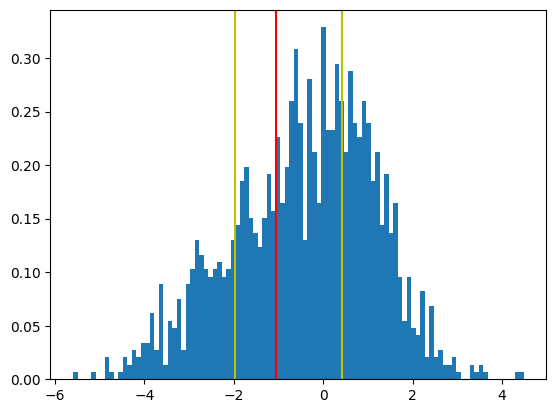

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 5455.245489783776 BIC 5465.799985237039 score -1.8836370040717954
Gaussian 0 mean= [-0.43521711] wgt= 1.0 cov= 2.532982181690059
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 5400.969067015703 BIC 5427.355305648861 score -1.8628089381533184
Gaussian 0 mean= [0.43124792] wgt= 0.6381778972410582 cov= 1.0968642332549636
Gaussian 1 mean= [-1.96347873] wgt= 0.3618221027589418 cov= 1.406222588561241
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 5415.635840613799 BIC 5457.8538224268505 score -1.865803676784312
Gaussian 0 mean= [0.93215083] wgt= 0.3892196199022239 cov= 0.7758015421539145
Gaussian 1 mean= [-2.43321913] wgt= 0.25453196733501454 cov= 1.0021622607807126
Gaussian 2 mean= [-0.5016063] wgt= 0.3562484127627615 cov= 0.6471770545484983
Cell Line 1 H1.hESC
Single mean [-0.39739329]
Double mean [0.29904008] [-1.46238547]
Gaussian discriminant -1.1683728356457594


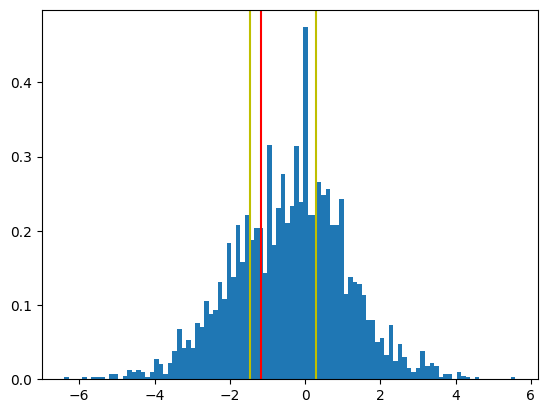

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 12222.65845590819 BIC 12234.878108460227 score -1.8362877150448136
Gaussian 0 mean= [-0.39739329] wgt= 1.0 cov= 2.304119937500234
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 12244.08749275079 BIC 12274.636624130882 score -1.8386064762174317
Gaussian 0 mean= [0.29904008] wgt= 0.6046194696484086 cov= 1.5116527654287348
Gaussian 1 mean= [-1.46238547] wgt= 0.3953805303515913 cov= 1.6400634347592609
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 12237.049486056118 BIC 12285.928096264266 score -1.8366470523078025
Gaussian 0 mean= [-0.1068324] wgt= 0.44942869024550736 cov= 0.6697313856044066
Gaussian 1 mean= [-1.85119894] wgt= 0.33236805350318804 cov= 1.2263716715950144
Gaussian 2 mean= [1.21858697] wgt= 0.21820325625130454 cov= 1.3074154617782028
Cell Line 2 HeLa.S3
Single mean [-1.51291487]
Double mean [-0.38717568] [-2.83979272]
Gaussian discriminant -1.8357285432167136


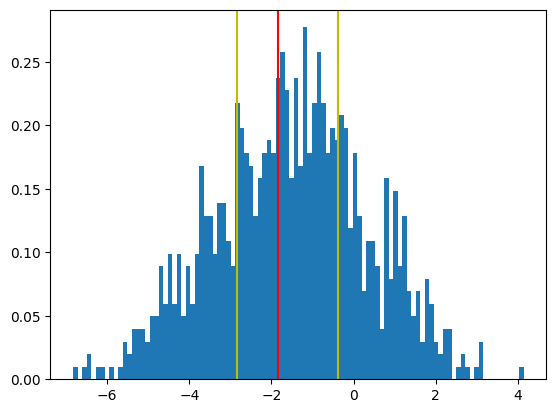

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 3743.8015907714002 BIC 3753.4481630161117 score -2.03471250858074
Gaussian 0 mean= [-1.51291487] wgt= 1.0 cov= 3.4265305321314274
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 3746.983458911297 BIC 3771.0998895230755 score -2.033179248591565
Gaussian 0 mean= [-0.38717568] wgt= 0.5410049066161108 cov= 1.8961507061839822
Gaussian 1 mean= [-2.83979272] wgt= 0.4589950933838892 cov= 1.9760239553602623
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 3747.0324479379983 BIC 3785.618736916844 score -2.0299414841882473
Gaussian 0 mean= [-1.24009763] wgt= 0.4509492366410183 cov= 0.7473787482397464
Gaussian 1 mean= [-3.4360177] wgt= 0.3296382603452081 cov= 1.3180720394222856
Gaussian 2 mean= [0.81558301] wgt= 0.21941250301377346 cov= 0.9694408675244972
Cell Line 3 HepG2
Single mean [-1.30047092]
Double mean [-0.1910402] [-2.79951756]
Gaussian discriminant -2.119632799634747


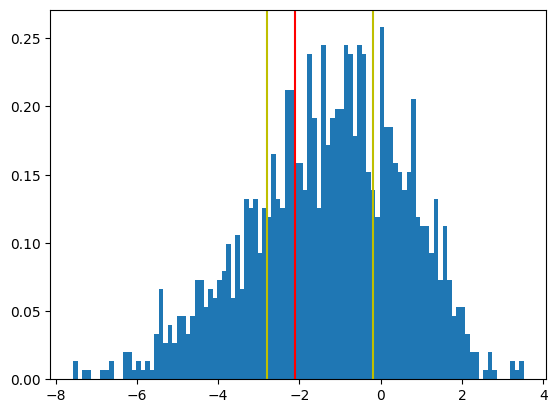

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 5624.991226766171 BIC 5635.42464573959 score -2.063506324069813
Gaussian 0 mean= [-1.30047092] wgt= 1.0 cov= 3.629648665536366
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 5587.563962778626 BIC 5613.647510212173 score -2.047563862987748
Gaussian 0 mean= [-0.1910402] wgt= 0.5746826356311242 cov= 1.5920167179065272
Gaussian 1 mean= [-2.79951756] wgt= 0.4253173643688757 cov= 2.472638095894782
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 5589.030502565282 BIC 5630.764178458958 score -2.0458995971238187
Gaussian 0 mean= [-3.74341797] wgt= 0.22802254240092287 cov= 1.7055506682019128
Gaussian 1 mean= [0.52555801] wgt= 0.34837261744558073 cov= 0.9099219588538646
Gaussian 2 mean= [-1.48718144] wgt= 0.42360484015349636 cov= 0.9125060482957584
Cell Line 4 HT1080
Single mean [-0.46008133]
Double mean [0.4677353] [-1.9755604]
Gaussian discriminant -1.5357515544302132


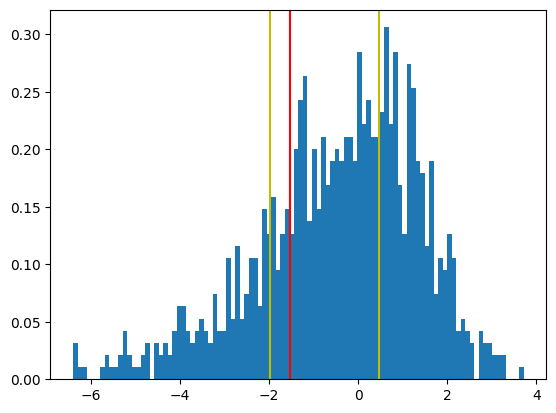

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 3767.295591108158 BIC 3776.978822061113 score -2.010307473882563
Gaussian 0 mean= [-0.46008133] wgt= 1.0 cov= 3.2632975018688977
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 3701.1932576093764 BIC 3725.401334991764 score -1.9717912700904787
Gaussian 0 mean= [0.4677353] wgt= 0.6202601965313503 cov= 1.2892192578979047
Gaussian 1 mean= [-1.9755604] wgt= 0.37973980346864966 cov= 2.784958061217208
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 3696.568580778382 BIC 3735.301504590203 score -1.9661156948602467
Gaussian 0 mean= [-1.09065974] wgt= 0.3701681334000766 cov= 0.7878802951261944
Gaussian 1 mean= [0.89372077] wgt= 0.4882942564003967 cov= 0.82829771621087
Gaussian 2 mean= [-3.48142497] wgt= 0.14153761019952665 cov= 1.6465031696072152
Cell Line 5 HUVEC
Single mean [-1.20761606]
Double mean [0.04776431] [-2.73314432]
Gaussian discriminant -1.7462501225468436


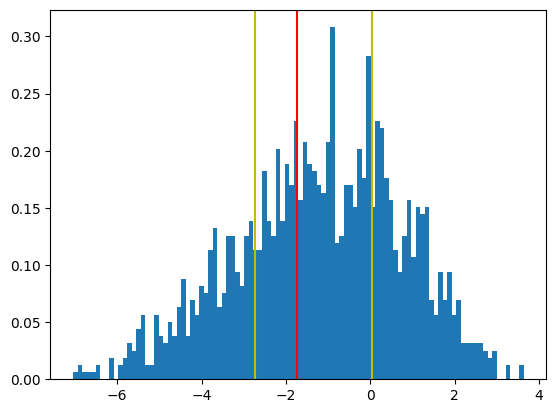

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 6242.983688957855 BIC 6253.594065388641 score -2.0964326911820748
Gaussian 0 mean= [-1.20761606] wgt= 1.0 cov= 3.87671666064744
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 6209.784983825221 BIC 6236.310924902186 score -2.083261083274604
Gaussian 0 mean= [0.04776431] wgt= 0.5485718765955526 cov= 1.656022894199873
Gaussian 1 mean= [-2.73314432] wgt= 0.4514281234044473 cov= 2.3329313865060177
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 6210.68627730212 BIC 6253.127783025265 score -2.0815478082332395
Gaussian 0 mean= [-1.52209393] wgt= 0.3858748264602023 cov= 0.8482044378173684
Gaussian 1 mean= [0.60818257] wgt= 0.38791838371263776 cov= 1.0565393864029329
Gaussian 2 mean= [-3.78504784] wgt= 0.22620678982715994 cov= 1.4131375975772567
Cell Line 6 MCF.7
Single mean [-1.4670061]
Double mean [-0.15041204] [-3.1447082]
Gaussian discriminant -2.335336639097255


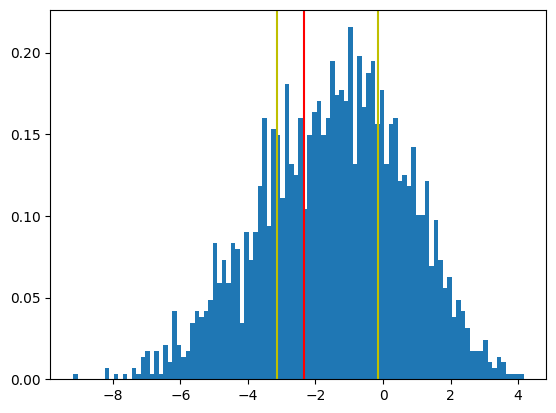

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 9429.203288235556 BIC 9440.555308099614 score -2.1858078126705833
Gaussian 0 mean= [-1.4670061] wgt= 1.0 cov= 4.635475462483851
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 9396.069626792936 BIC 9424.449676453081 score -2.176732288217286
Gaussian 0 mean= [-0.15041204] wgt= 0.5602993197323368 cov= 2.146295917275557
Gaussian 1 mean= [-3.1447082] wgt= 0.4397006802676633 cov= 2.7838362742074745
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 9409.338710242992 BIC 9454.746789699222 score -2.1784180682381704
Gaussian 0 mean= [-3.95419881] wgt= 0.26909385609620134 cov= 2.0239831173651437
Gaussian 1 mean= [0.63837672] wgt= 0.33446156543983124 cov= 1.3670964078430057
Gaussian 2 mean= [-1.55499156] wgt= 0.39644457846396736 cov= 1.219157074031988
Cell Line 7 NCI.H460
Single mean [-1.54018314]
Double mean [-2.74715336] [-0.8183658]
Gaussian discriminant -3.6877702370005556


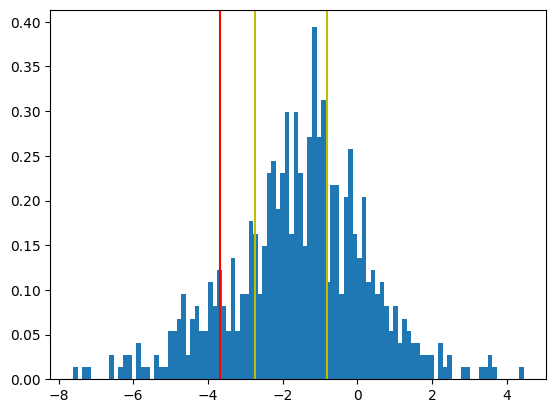

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 2475.302350249103 BIC 2484.1292681634377 score -2.025657664138609
Gaussian 0 mean= [-1.54018314] wgt= 1.0 cov= 3.365035655543331
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 2476.5390363017077 BIC 2498.6063310875443 score -2.0217533084440227
Gaussian 0 mean= [-2.74715336] wgt= 0.3742337173994786 cov= 3.1035813484460935
Gaussian 1 mean= [-0.8183658] wgt= 0.6257662826005216 cov= 2.1291636692153393
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 2471.5731754622357 BIC 2506.8808471195744 score -2.0127648979198653
Gaussian 0 mean= [-1.48868962] wgt= 0.5050284322242862 cov= 0.9037268077844581
Gaussian 1 mean= [-3.95334809] wgt= 0.20687807970101244 cov= 1.7390336848748784
Gaussian 2 mean= [0.10242685] wgt= 0.28809348807470125 cov= 1.962799506431542
Cell Line 8 NHEK
Single mean [-1.09901546]
Double mean [-0.09947439] [-2.82133356]
Gaussian discriminant -2.476476580374999


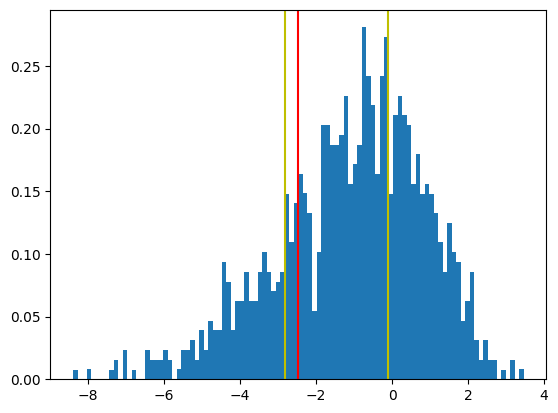

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 4514.108226758826 BIC 4524.077659399063 score -2.088013067943901
Gaussian 0 mean= [-1.09901546] wgt= 1.0 cov= 3.811982259058879
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 4444.2648491728905 BIC 4469.188430773482 score -2.0529003931355976
Gaussian 0 mean= [-0.09947439] wgt= 0.6327726715139191 cov= 1.5350524021292211
Gaussian 1 mean= [-2.82133356] wgt= 0.36722732848608075 cov= 3.0474730331331266
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 4451.093641974026 BIC 4490.971372534972 score -2.0532840935064933
Gaussian 0 mean= [-3.8196002] wgt= 0.20182015093835717 cov= 2.1695266587377313
Gaussian 1 mean= [0.54468583] wgt= 0.39945793585932615 cov= 0.9368606340675901
Gaussian 2 mean= [-1.36867885] wgt= 0.3987219132023167 cov= 0.9978682777270845
Cell Line 9 SK.MEL.5
Single mean [-1.68603146]
Double mean [-0.77620351] [-3.417828]
Gaussian discriminant -4.4182336951321535


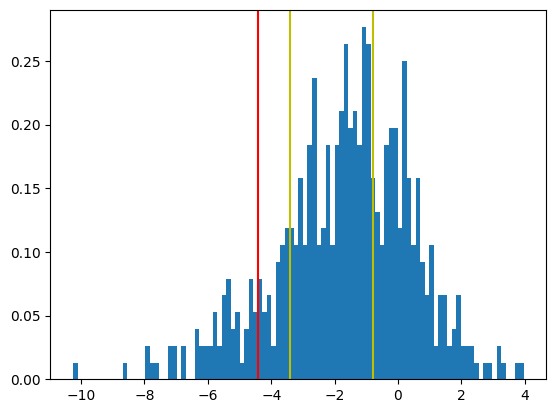

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 2332.7751361684614 BIC 2341.3359278463818 score -2.1805010638281472
Gaussian 0 mean= [-1.68603146] wgt= 1.0 cov= 4.586537028380253
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 2316.4489912232193 BIC 2337.85097041802 score -2.159596433729606
Gaussian 0 mean= [-0.77620351] wgt= 0.6555801348848068 cov= 2.331504930707909
Gaussian 1 mean= [-3.417828] wgt= 0.3444198651151931 cov= 4.30408336529661
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 2324.383704193174 BIC 2358.6268709048554 score -2.161407962727691
Gaussian 0 mean= [-4.54748849] wgt= 0.1996049378115682 cov= 3.0418064022023144
Gaussian 1 mean= [-1.81221764] wgt= 0.4651696304585291 cov= 1.3278112830547204
Gaussian 2 mean= [0.19288008] wgt= 0.3352254317299028 cov= 1.6004494187518106
Cell Line 10 SK.N.DZ
Single mean [-0.57847749]
Double mean [0.04100442] [-1.96505581]
Gaussian discriminant 0.41957006423860377


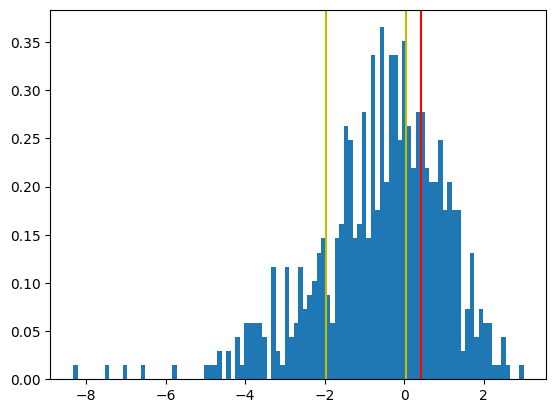

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 2277.460521247609 BIC 2286.2643556410635 score -1.8851248103214004
Gaussian 0 mean= [-0.57847749] wgt= 1.0 cov= 2.5405305771348514
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 2222.358590891635 BIC 2244.368176875271 score -1.8344598597774748
Gaussian 0 mean= [0.04100442] wgt= 0.6911947613088845 cov= 1.108929272593024
Gaussian 1 mean= [-1.96505581] wgt= 0.3088052386911156 cov= 2.963305580970507
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 2229.2124900642875 BIC 2264.427827638105 score -1.8351679022091936
Gaussian 0 mean= [-0.70209985] wgt= 0.43579533674632226 cov= 0.6619240444544999
Gaussian 1 mean= [-2.5588538] wgt= 0.21353402553660467 cov= 2.563018525869065
Gaussian 2 mean= [0.78106541] wgt= 0.3506706377170732 cov= 0.6059644633546245
Cell Line 11 SK.N.SH
Single mean [-1.25692489]
Double mean [-0.08863885] [-2.97037948]
Gaussian discriminant -2.583269439329749


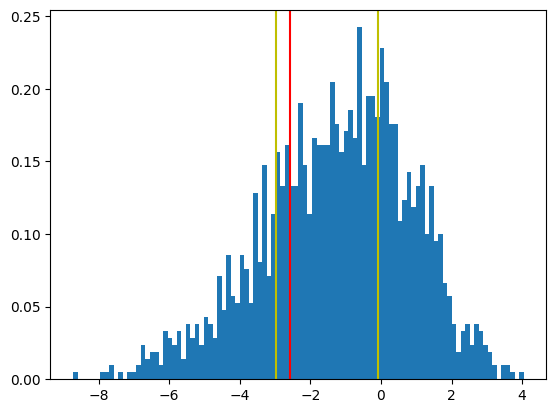

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 7122.564132351813 BIC 7133.377553812168 score -2.161069864101947
Gaussian 0 mean= [-1.25692489] wgt= 1.0 cov= 4.4117122899458465
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 7078.660382703687 BIC 7105.693936354575 score -2.145919970462564
Gaussian 0 mean= [-0.08863885] wgt= 0.5945901471841359 cov= 1.992967755921007
Gaussian 1 mean= [-2.97037948] wgt= 0.405409852815864 cov= 3.0214071081195746
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 7081.82215161153 BIC 7125.075837452951 score -2.1450583338225653
Gaussian 0 mean= [-4.13562637] wgt= 0.1878806253002586 cov= 2.206377820397477
Gaussian 1 mean= [-1.70531297] wgt= 0.41050594697490034 cov= 1.2828499165438318
Gaussian 2 mean= [0.54808997] wgt= 0.4016134277248411 cov= 1.301216140418657
Cell Line 12 GM12878
Single mean [-1.06966594]
Double mean [-0.18121309] [-2.30122633]
Gaussian discriminant -1.621706374598696


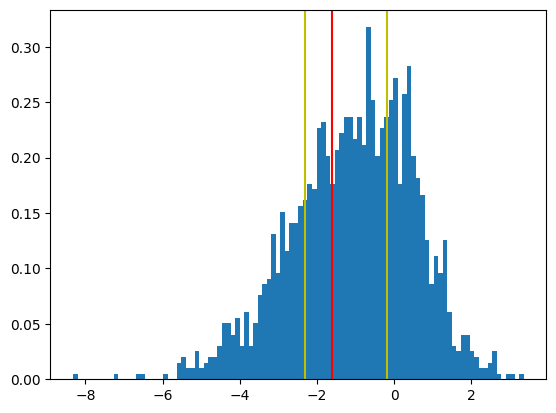

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 6387.499161968057 BIC 6398.373574701799 score -1.8797111784358236
Gaussian 0 mean= [-1.06966594] wgt= 1.0 cov= 2.5131719699822703
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 6349.942476419072 BIC 6377.128508253428 score -1.8668852992989022
Gaussian 0 mean= [-0.18121309] wgt= 0.580921083472095 cov= 1.1412690633603797
Gaussian 1 mean= [-2.30122633] wgt= 0.41907891652790497 cov= 1.8039594463789637
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 6357.038192997191 BIC 6400.535843932161 score -1.8672079484679596
Gaussian 0 mean= [-1.37266962] wgt= 0.38276150169201106 cov= 0.7828227509683131
Gaussian 1 mean= [0.27251576] wgt= 0.3987399609041427 cov= 0.7805822093130916
Gaussian 2 mean= [-2.98822952] wgt= 0.21849853740384614 cov= 1.5769780225505972
Cell Line 13 K562
Single mean [-0.88045596]
Double mean [-0.13619923] [-2.51238068]
Gaussian discriminant -2.0572214963833813


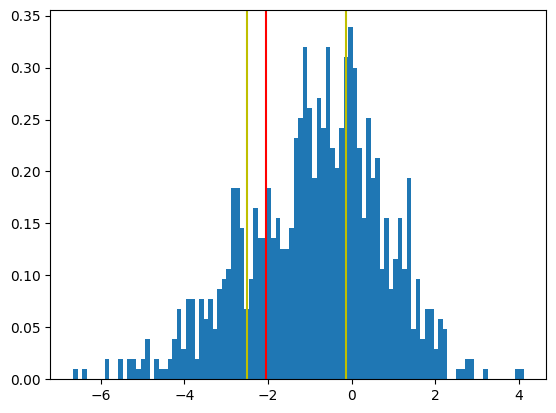

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 3666.972824623317 BIC 3676.702520179259 score -1.911781223707368
Gaussian 0 mean= [-0.88045596] wgt= 1.0 cov= 2.679648834913383
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 3643.50121209129 BIC 3667.8254509811445 score -1.8963993800058927
Gaussian 0 mean= [-0.13619923] wgt= 0.686784555266578 cov= 1.3336548461425508
Gaussian 1 mean= [-2.51238068] wgt= 0.31321544473342194 cov= 1.753247909985905
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 3654.417337504085 BIC 3693.336119727852 score -1.8989652074655976
Gaussian 0 mean= [-2.71987757] wgt= 0.2956676317383152 cov= 1.4139715307206149
Gaussian 1 mean= [0.69520308] wgt= 0.2971694885574727 cov= 0.8878533708756896
Gaussian 2 mean= [-0.69473264] wgt= 0.40716287970421217 cov= 0.6030258318565481
Cell Line 14 IMR.90
Single mean [-0.58515997]
Double mean [-2.45654744] [0.59234137]
Gaussian discriminant -1.6358697265885764


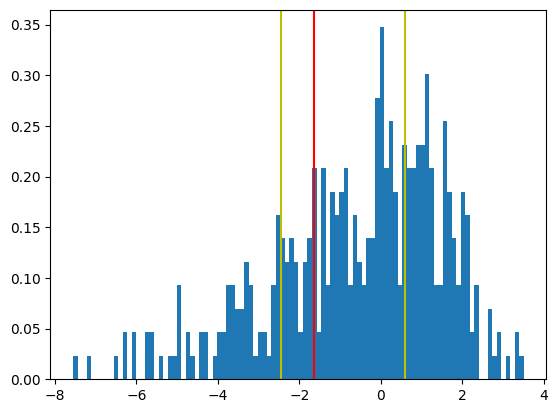

GaussianMixture(covariance_type='spherical', n_init=10)
AIC 1685.2162623623524 BIC 1693.1485558405998 score -2.1554054645671186
Gaussian 0 mean= [-0.58515997] wgt= 1.0 cov= 4.362014936374219
GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 1645.5717331614655 BIC 1665.402466857084 score -2.0968868373864944
Gaussian 0 mean= [-2.45654744] wgt= 0.3862067184093256 cov= 3.4021406393706295
Gaussian 1 mean= [0.59234137] wgt= 0.6137932815906745 cov= 1.3759096540358358
GaussianMixture(covariance_type='spherical', n_components=3, n_init=10)
AIC 1645.7631771831573 BIC 1677.4923510961469 score -2.0894399707476374
Gaussian 0 mean= [0.89646616] wgt= 0.536750207380222 cov= 0.9580351893247355
Gaussian 1 mean= [-1.45343265] wgt= 0.3094761102069341 cov= 0.9625216546021108
Gaussian 2 mean= [-4.00937062] wgt= 0.1537736824128438 cov= 2.1803858521966815


In [8]:
filename = DATA_DIR + RCI_FILE
loader = RCI_Loader()

for CELL_LINE in range(15):
    gene_to_rci = loader.load_gene_rci_values(filename,CELL_LINE)
    logs = list(gene_to_rci.values())
    values = np.array(logs)
    values = values.reshape(-1, 1)

    model_1 = GaussianMixture(n_components=1, verbose=0, covariance_type='spherical', n_init=10) 
    model_1.fit(values)
    model_2 = GaussianMixture(n_components=2, verbose=0, covariance_type='spherical', n_init=10) 
    model_2.fit(values)
    model_3 = GaussianMixture(n_components=3, verbose=0, covariance_type='spherical', n_init=10) 
    model_3.fit(values)
    
    discrim = place_discriminant(
        min(logs),max(logs),
        model_2.means_[0],model_2.covariances_[0],model_2.weights_[0],
        model_2.means_[1],model_2.covariances_[1],model_2.weights_[1])
    
    print('Cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print('Single mean',model_1.means_[0])
    print('Double mean',model_2.means_[0],model_2.means_[1])
    print('Gaussian discriminant',discrim)
    if discrim is None:   # not expected, but just in case...
        discrim = model_1.means_
    left =  model_2.means_[0]
    right = model_2.means_[1]
    plot(logs,left,right,discrim)
    
    show_gmm(model_1,values)
    show_gmm(model_2,values)
    show_gmm(model_3,values)